###### import  module "Functions", to use some predefined tools

In [1]:
import Functions

###### import librairies

In [139]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from glob import glob
from matplotlib import patches

###### create the function to detect the fourth coordinates of a plate

In [116]:
# this folder is used to save the image
temp_folder = 'saved_img/'

X0 = 0
Y0 = 0
dx = 0
dy = 0
def detect(image):
    global X0
    global Y0
    global dx
    global dy
    #image = image's path


    img = cv2.imread(image)
    # plt.show(img)
    # cv2.imwrite(temp_folder + '1 - original.png', img)

    # hsv transform - value = gray image
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hue, saturation, value = cv2.split(hsv)
    # plt.show(value)
    # cv2.imwrite(temp_folder + '2 - gray.png', value)

    # kernel to use for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # applying topHat/blackHat operations
    topHat = cv2.morphologyEx(value, cv2.MORPH_TOPHAT, kernel)
    blackHat = cv2.morphologyEx(value, cv2.MORPH_BLACKHAT, kernel)
    # plt.show(topHat)
    # plt.show(blackHat)
    # cv2.imwrite(temp_folder + '3 - topHat.png', topHat)
    # cv2.imwrite(temp_folder + '4 - blackHat.png', blackHat)

    # add and subtract between morphological operations
    add = cv2.add(value, topHat)
    subtract = cv2.subtract(add, blackHat)
    # plt.show(subtract)
    # cv2.imwrite(temp_folder + '5 - subtract.png', subtract)

    # applying gaussian blur on subtract image
    blur = cv2.GaussianBlur(subtract, (5, 5), 0)
    # plt.show(blur)
    # cv2.imwrite(temp_folder + '6 - blur.png', blur)

    # thresholding
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 9)
    # plt.show(thresh)
    # cv2.imwrite(temp_folder + '7 - thresh.png', thresh)

    # check for contours on thresh
    imageContours, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # get height and width
    height, width = thresh.shape

    # create a numpy array with shape given by threshed image value dimensions
    imageContours = np.zeros((height, width, 3), dtype=np.uint8)

    # list and counter of possible chars
    possibleChars = []
    countOfPossibleChars = 0

    # loop to check if any (possible) char is found
    for i in range(0, len(contours)):

        # draw contours based on actual found contours of thresh image
        cv2.drawContours(imageContours, contours, i, (255, 255, 255))

        # retrieve a possible char by the result ifChar class give us
        possibleChar = Functions.ifChar(contours[i])

        # by computing some values (area, width, height, aspect ratio) possibleChars list is being populated
        if Functions.checkIfChar(possibleChar) is True:
            countOfPossibleChars = countOfPossibleChars + 1
            possibleChars.append(possibleChar)

    # plt.show(imageContours)
    # cv2.imwrite(temp_folder + '8 - imageContours.png', imageContours)

    imageContours = np.zeros((height, width, 3), np.uint8)

    ctrs = []

    # populating ctrs list with each char of possibleChars
    for char in possibleChars:
        ctrs.append(char.contour)

    # using values from ctrs to draw new contours
    cv2.drawContours(imageContours, ctrs, -1, (255, 255, 255))
    # plt.show(imageContours)
    # cv2.imwrite(temp_folder + '9 - contoursPossibleChars.png', imageContours)

    plates_list = []
    listOfListsOfMatchingChars = []

    for possibleC in possibleChars:

        # the purpose of this function is, given a possible char and a big list of possible chars,
        # find all chars in the big list that are a match for the single possible char, and return those matching chars as a list
        def matchingChars(possibleC, possibleChars):
            listOfMatchingChars = []

            # if the char we attempting to find matches for is the exact same char as the char in the big list we are currently checking
            # then we should not include it in the list of matches b/c that would end up double including the current char
            # so do not add to list of matches and jump back to top of for loop
            for possibleMatchingChar in possibleChars:
                if possibleMatchingChar == possibleC:
                    continue

                # compute stuff to see if chars are a match
                distanceBetweenChars = Functions.distanceBetweenChars(possibleC, possibleMatchingChar)

                angleBetweenChars = Functions.angleBetweenChars(possibleC, possibleMatchingChar)

                changeInArea = float(abs(possibleMatchingChar.boundingRectArea - possibleC.boundingRectArea)) / float(
                    possibleC.boundingRectArea)

                changeInWidth = float(abs(possibleMatchingChar.boundingRectWidth - possibleC.boundingRectWidth)) / float(
                    possibleC.boundingRectWidth)

                changeInHeight = float(abs(possibleMatchingChar.boundingRectHeight - possibleC.boundingRectHeight)) / float(
                    possibleC.boundingRectHeight)

                # check if chars match
                if distanceBetweenChars < (possibleC.diagonalSize * 5) and \
                        angleBetweenChars < 12.0 and \
                        changeInArea < 0.5 and \
                        changeInWidth < 0.8 and \
                        changeInHeight < 0.2:
                    listOfMatchingChars.append(possibleMatchingChar)

            return listOfMatchingChars


        # here we are re-arranging the one big list of chars into a list of lists of matching chars
        # the chars that are not found to be in a group of matches do not need to be considered further
        listOfMatchingChars = matchingChars(possibleC, possibleChars)

        listOfMatchingChars.append(possibleC)

        # if current possible list of matching chars is not long enough to constitute a possible plate
        # jump back to the top of the for loop and try again with next char
        if len(listOfMatchingChars) < 3:
            continue

        # here the current list passed test as a "group" or "cluster" of matching chars
        listOfListsOfMatchingChars.append(listOfMatchingChars)

        # remove the current list of matching chars from the big list so we don't use those same chars twice,
        # make sure to make a new big list for this since we don't want to change the original big list
        listOfPossibleCharsWithCurrentMatchesRemoved = list(set(possibleChars) - set(listOfMatchingChars))

        recursiveListOfListsOfMatchingChars = []

        for recursiveListOfMatchingChars in recursiveListOfListsOfMatchingChars:
            listOfListsOfMatchingChars.append(recursiveListOfMatchingChars)

        break

    imageContours = np.zeros((height, width, 3), np.uint8)

    for listOfMatchingChars in listOfListsOfMatchingChars:
        contoursColor = (255, 0, 255)

        contours = []

        for matchingChar in listOfMatchingChars:
            contours.append(matchingChar.contour)

        cv2.drawContours(imageContours, contours, -1, contoursColor)

    # plt.show(imageContours)
    # cv2.imwrite(temp_folder + '10 - finalContours.png', imageContours)

    for listOfMatchingChars in listOfListsOfMatchingChars:
        possiblePlate = Functions.PossiblePlate()

        # sort chars from left to right based on x position
        listOfMatchingChars.sort(key=lambda matchingChar: matchingChar.centerX)

        # calculate the center point of the plate
        plateCenterX = (listOfMatchingChars[0].centerX + listOfMatchingChars[len(listOfMatchingChars) - 1].centerX) / 2.0
        plateCenterY = (listOfMatchingChars[0].centerY + listOfMatchingChars[len(listOfMatchingChars) - 1].centerY) / 2.0

        plateCenter = plateCenterX, plateCenterY

        # calculate plate width and height
        plateWidth = int((listOfMatchingChars[len(listOfMatchingChars) - 1].boundingRectX + listOfMatchingChars[
            len(listOfMatchingChars) - 1].boundingRectWidth - listOfMatchingChars[0].boundingRectX) * 1.3)

        totalOfCharHeights = 0

        for matchingChar in listOfMatchingChars:
            totalOfCharHeights = totalOfCharHeights + matchingChar.boundingRectHeight

        averageCharHeight = totalOfCharHeights / len(listOfMatchingChars)

        plateHeight = int(averageCharHeight * 1.5)

        # calculate correction angle of plate region
        opposite = listOfMatchingChars[len(listOfMatchingChars) - 1].centerY - listOfMatchingChars[0].centerY

        hypotenuse = Functions.distanceBetweenChars(listOfMatchingChars[0],
                                                    listOfMatchingChars[len(listOfMatchingChars) - 1])
        correctionAngleInRad = math.asin(opposite / hypotenuse)
        correctionAngleInDeg = correctionAngleInRad * (180.0 / math.pi)

        # pack plate region center point, width and height, and correction angle into rotated rect member variable of plate
        possiblePlate.rrLocationOfPlateInScene = (tuple(plateCenter), (plateWidth, plateHeight), correctionAngleInDeg)

        # get the rotation matrix for our calculated correction angle
        rotationMatrix = cv2.getRotationMatrix2D(tuple(plateCenter), correctionAngleInDeg, 1.0)

        height, width, numChannels = img.shape

        # rotate the entire image
        imgRotated = cv2.warpAffine(img, rotationMatrix, (width, height))

        # crop the image/plate detected
        imgCropped = cv2.getRectSubPix(imgRotated, (plateWidth, plateHeight), tuple(plateCenter))

        # copy the cropped plate image into the applicable member variable of the possible plate
        possiblePlate.Plate = imgCropped

        # populate plates_list with the detected plate
        if possiblePlate.Plate is not None:
            plates_list.append(possiblePlate)

        # draw a ROI on the original image
        for i in range(0, len(plates_list)):
            # finds the four vertices of a rotated rect - it is useful to draw the rectangle.
            p2fRectPoints = cv2.boxPoints(plates_list[i].rrLocationOfPlateInScene)

            # roi rectangle colour
            rectColour = (0, 255, 0)

            cv2.line(imageContours, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), rectColour, 2)
            cv2.line(imageContours, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), rectColour, 2)
            cv2.line(imageContours, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), rectColour, 2)
            cv2.line(imageContours, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), rectColour, 2)

            cv2.line(img, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), rectColour, 2)
            cv2.line(img, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), rectColour, 2)
            cv2.line(img, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), rectColour, 2)
            cv2.line(img, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), rectColour, 2)
            
            fig = plt.figure()
        
            #ax1 = fig.add_subplot(2,2,1)
            #ax1.imshow(imageContours)
        
            ##ax1 = fig.add_subplot(2,2,1)
            ##ax1.imshow(img)
        
            ##ax2 = fig.add_subplot(2,2,2)
            ##ax2.imshow(plates_list[i].Plate)
            X0 = tuple(p2fRectPoints[0])[0]
            Y0 = tuple(p2fRectPoints[1])[1]
            dx = tuple(p2fRectPoints[2])[0] - X0
            dy = tuple(p2fRectPoints[0])[1] - Y0
            
            cv2.imwrite(temp_folder + '11 - detected.png', imageContours)
            cv2.imwrite(temp_folder + '12 - detectedOriginal.png', img)
            cv2.imwrite(temp_folder + '13 - plate.png', plates_list[i].Plate)
    return(list([X0, Y0, dx,dy]))

    #cv2.waitKey(0)

In [117]:
## FUNTION TO STORE JPGs IN A LIST
def find_jpgs_txts(directory):
    files=[]
    for i in range(0, len(directory)):
        f= directory[i].rsplit('\\', 1)
        files.append(f[1])
    return files

In [118]:
annotations = []
images = []

dr2 = '../../endtoend/'

### loop to store all paths to  images and annotations in lists
for countr in ['eu', 'br', 'us']:  
    
    print(countr + ' ...')
    txt_files = glob(dr2 + countr + '/*.txt')
    jpg_files = glob(dr2 + countr + '/*.jpg')
    
    jpg_list = find_jpgs_txts(jpg_files)
    #print(countr + " " + str(len(jpg_list)))
    
    txt_list = find_jpgs_txts(txt_files)
    #print(countr + " " + str(len(txt_list)))
    
    for i in range(len(jpg_list)):
        pic = dr2 + countr + "/" + jpg_list[i]
        annot = dr2 + countr + "/" + txt_list[i]
        
        annotations.append(annot)
        images.append(pic)
        
    print('\n done for ' + countr + ' ...\n')
    
    
print("length annotations : " + str(len(annotations)))
print("length images : " + str(len(images)))

eu ...

 done for eu ...

br ...

 done for br ...

us ...

 done for us ...

length annotations : 444
length images : 444


In [119]:
images[52] , annotations[52]

('../../endtoend/eu/test_042.jpg', '../../endtoend/eu/test_042.txt')

###### function to extract coordinates of the plate from each line of the annotation's file

In [120]:
def preprocess_file(name):
    
    with open(name , 'r') as my_file:
        lines = my_file.readlines()
    line = lines[0][:-1]
    splits = line.split('\t')
    
    coords = list(map(int, splits[1:-1]))

    return coords

In [151]:
preprocess_file(annotations[200])

[450, 747, 338, 109]

In [153]:
###### result of detection function on one item

In [152]:
detect(images[200])

[411.56305, 766.63727, 413.3739, 78.82251]

<Figure size 432x288 with 0 Axes>

###### create arrays to evaluate the performance on the 444 images

In [123]:
y_test = []
y_pred = []

for i in range(len(annotations)):
    y_test.append(preprocess_file(annotations[i]))
    
    image_i = images[i]
    
    pred = detect(image = image_i)
    y_pred.append(pred)

y_test = np.array(y_test)
y_pred = np.array(y_pred)

C:\Users\EL MAHDI\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [124]:
from pandas import DataFrame
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [154]:
###### fucntion to make a report of the performances

In [125]:
def make_report(y_test, y_pred):
    
    r2_test = r2_score(y_true = y_test, y_pred = y_pred)
    
    
    mse_test = mean_squared_error(y_true = y_test, y_pred = y_pred)
    
    
    mae_test = mean_absolute_error(y_true = y_test, y_pred = y_pred)
    
    return DataFrame(
        data = {
            "R2" : [r2_test],
            "MSE" : [mse_test],
            "MAE" : [mae_test]
        },
        index = ["test"]
    )
    

In [126]:
make_report(y_test, y_pred)

,R2,MSE,MAE
test,0.00051,27210.027367,72.790512


In [129]:
len(y_test)

444

In [130]:
len(y_pred)

444

In [155]:
###### function to vizualize the prediction and the ground truth

In [140]:
def predict_and_vizualize(indice):
    
    img = cv2.imread(images[indice])
    coords = preprocess_file(annotations[indice])
    pred = detect(images[indice])
    
    fig,ax = plt.subplots(1, figsize = (20,10))
    
    


    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect_gt =patches.Rectangle((coords[0],coords[1]),coords[2] ,coords[3] ,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect_gt)
    
    rect_pred =patches.Rectangle((int(pred[0]),int(pred[1])),int(pred[2]) ,int(pred[3]) ,linewidth=1,edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect_pred)

    plt.show()
    
    #return list(map(int, pred))

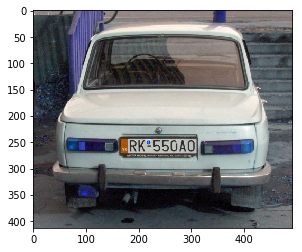

In [141]:
img = cv2.imread(images[100])
plt.imshow(img)

<Figure size 432x288 with 0 Axes>

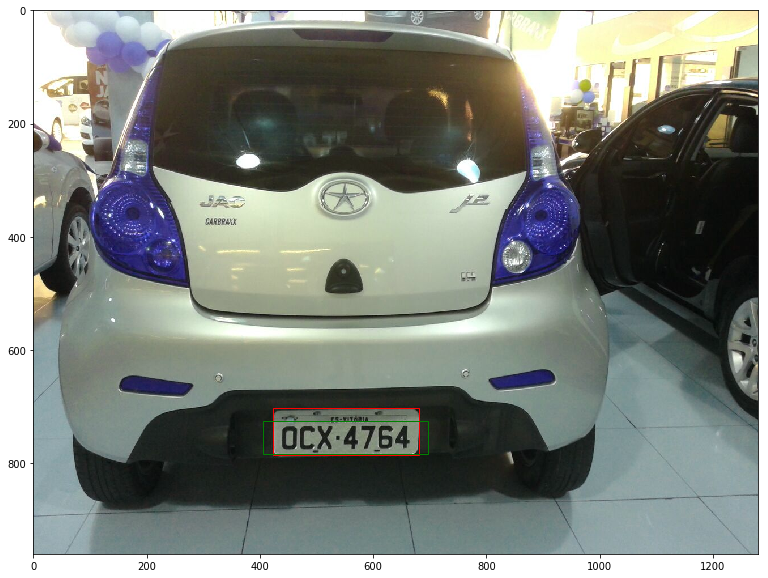

In [145]:
predict_and_vizualize(150)

<Figure size 432x288 with 0 Axes>

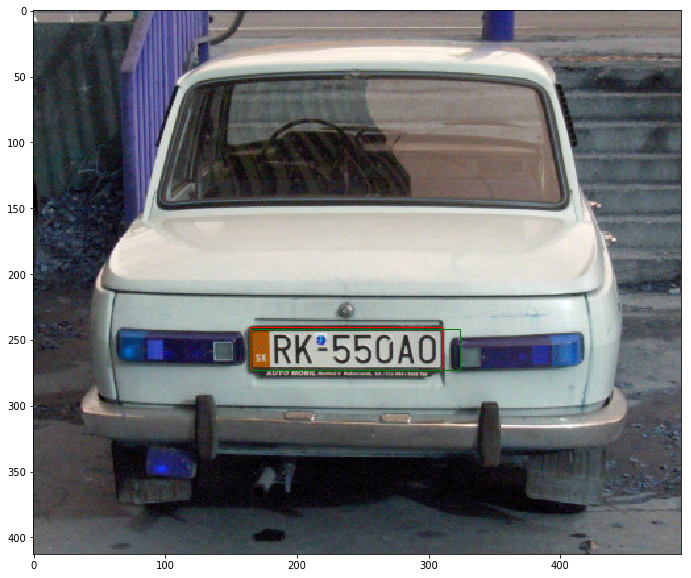

In [146]:
predict_and_vizualize(100)

<Figure size 432x288 with 0 Axes>

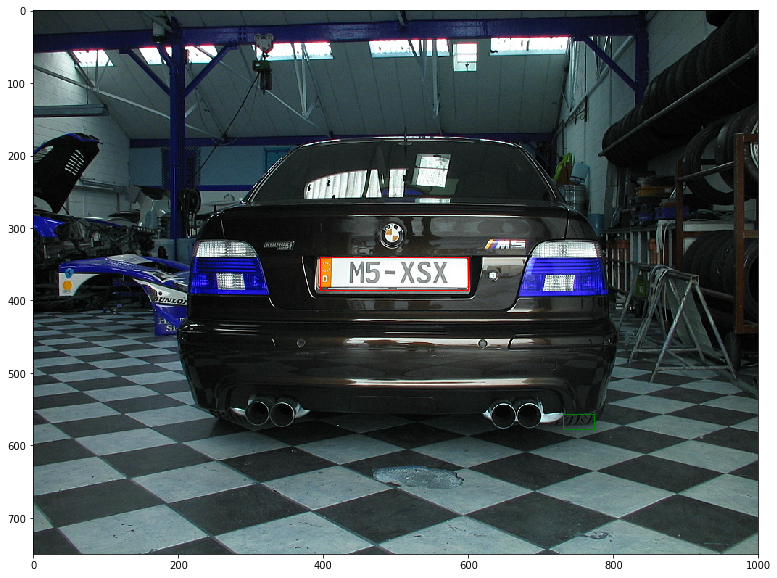

In [147]:
predict_and_vizualize(0)

<Figure size 432x288 with 0 Axes>

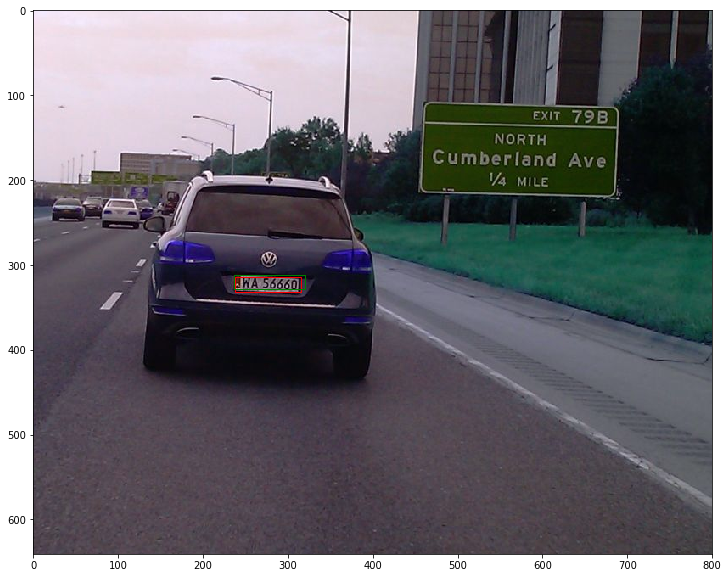

In [148]:
predict_and_vizualize(1)